# Okay, goals for Week 1-2:
Set up a python environment with all the software tools we'll be using. This includes numpy, matplotlib, astropy, lightkurve, and the things they require as dependencies.

1. Get some practice downloading and interacting with TESS data! I recommend doing a few of the tutorials here, specifically "What are light curves" "recover a planet" and "how to detrend" but also any other ones you find interesting. ✔

2. Have a read through of this paper if you haven't already: https://iopscience.iop.org/article/10.3847/1538-3881/ac223a Make a light curve with TESS data ✔, and measure the relative spacing of the primary and secondary eclipses. ✔

3. Download the WASP, KELT and ASAS-SN data (ASAS-SN ✔ is easiest, start there) for this target and see if you can reproduce their Figure 5, top panels. If we measure the period of the primary and secondary eclipses separately, do you see a difference? Is it significant?

In [1]:
import requests
import re
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import search_lightcurvefile
import pandas as pd
import os

%matplotlib inline

Let's access the TESS data and plot a light curve for it. We can use built-in python functions to search for the TESS object without having to interact with a website manually.

/Users/carolshao/anaconda3/envs/tess_cbp/lib/python3.12/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 14 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


19.853851226963293 d


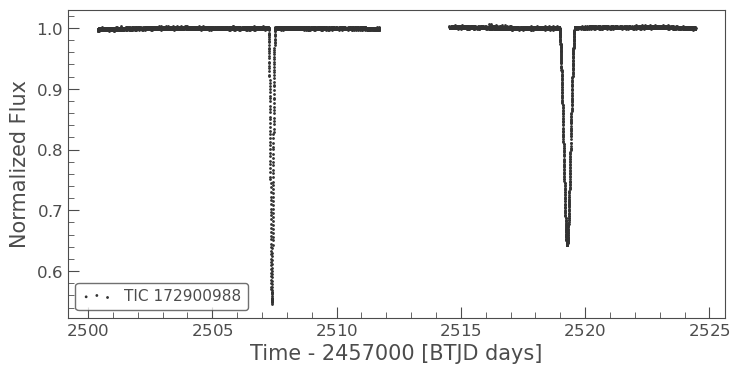

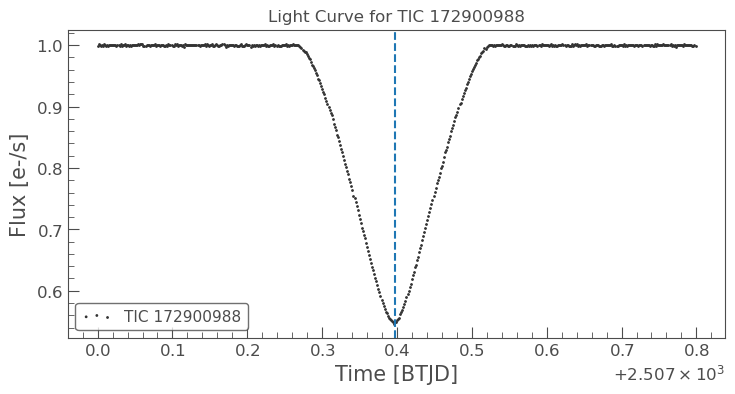

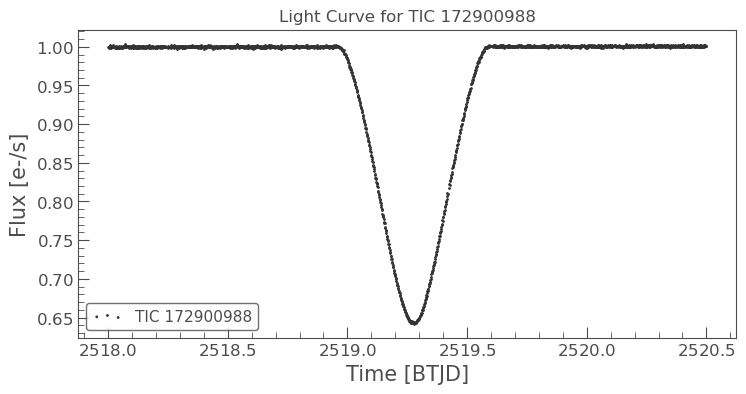

In [2]:
search_result = lk.search_lightcurve('TIC 172900988', mission='TESS')

# download the light curve data
lc = search_result.download().remove_nans().normalize()
lc.scatter()
periodogram = lc.to_periodogram(method='bls', minimum_period=18, maximum_period=20, duration=[0.3,0.5])
best_period = periodogram.period_at_max_power
print(best_period)

cropped_lc1 = lc[(lc.time.value >= 2507) & (lc.time.value <= 2507.8)]
cropped_lc2 = lc[(lc.time.value >= 2518) & (lc.time.value <= 2520.5)]

# for now, we manually identify the peak of the primary eclipse, for rough reference purposes
cropped_lc1.scatter()
plt.xlabel('Time [BTJD]')
plt.ylabel('Flux [e-/s]')
plt.axvline(x=2507.397, linestyle='--') 
plt.title('Light Curve for TIC 172900988')
plt.show()

cropped_lc2.scatter()
plt.xlabel('Time [BTJD]')
plt.ylabel('Flux [e-/s]')
plt.title('Light Curve for TIC 172900988')
plt.show()

In [3]:
search_result = lk.search_lightcurve('TIC 172900988', mission='TESS')
search_result[0]

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 44,2021,SPOC,120,172900988,0.0


Search for the TESS object using search_tesscut module and use the extracted coordinates to query for the same object in ASAS-SN data. There is something called 'pyasassn' which uses query language similar to SQL which will be helpful to us.

In [4]:
from lightkurve import search_tesscut
from pyasassn.client import SkyPatrolClient
import astroquery
from astroquery.mast import Catalogs

tic_id = 'TIC 172900988'

# query the TIC catalog for the target
tic_info = Catalogs.query_object(tic_id, radius=0.001, catalog="TIC")

for row in tic_info:
    print(row)
    
if tic_info is not None and len(tic_info) > 0:
    # extract RA, Dec, and radius
    ra = tic_info[0]['ra']
    dec = tic_info[0]['dec']
    radius = tic_info[0]['rad']

    print(f"TIC ID: {tic_id}")
    print(f"RA: {ra} degrees")
    print(f"Dec: {dec} degrees")
    print(f"Radius: {radius} solar radii")
else:
    print(f"No information found for TIC ID: {tic_id}")

client = SkyPatrolClient()
client.catalogs.master_list

# query for the asas-sn object id
query = """
SELECT 
 * 
FROM master_list 
WHERE DISTANCE(ra_deg, dec_deg, 128.661697628763, 31.554078073408) <= 0.01
"""
asassn_lc = client.adql_query(query, download=True)

    ID           ra              dec         pmRA   pmDEC    Tmag  objType typeSrc version  HIP     TYC         UCAC        TWOMASS      SDSS       ALLWISE              GAIA         APASS   KIC POSflag   e_pmRA  e_pmDEC  PMflag   plx     e_plx   PARflag     gallong           gallat           eclong           eclat        Bmag  e_Bmag  Vmag  e_Vmag umag e_umag gmag e_gmag rmag e_rmag imag e_imag zmag e_zmag Jmag e_Jmag  Hmag e_Hmag  Kmag e_Kmag       TWOMflag      prox w1mag e_w1mag w2mag e_w2mag w3mag e_w3mag w4mag e_w4mag GAIAmag e_GAIAmag e_Tmag TESSflag SPFlag  Teff   e_Teff   logg    e_logg   MH e_MH   rad     e_rad   mass  e_mass    rho      e_rho   lumclass    lum       e_lum      d     e_d     ebv       e_ebv    numcont   contratio    disposition duplicate_id   priority    eneg_EBV   epos_EBV   EBVflag  eneg_Mass epos_Mass eneg_Rad  epos_Rad  eneg_rho  epos_rho eneg_logg epos_logg eneg_lum epos_lum eneg_dist epos_dist distflag eneg_Teff epos_Teff TeffFlag  gaiabp e_gaiabp  gaiar

In [5]:
asassn_lc

LightCurveCollection with 1 light curves 
     asas_sn_id      ra_deg    dec_deg                catalog_sources
0  171799744865  128.661664  31.553979  [stellar_main, tic, aavsovsx]

Add a quality flag filter onto the data and remove the invalid negative flux points. We also normalize the data using the median overall flux and then make the data into a dataframe (to then be converted into a lightkurve obj).

Best period: 19.7148 d days


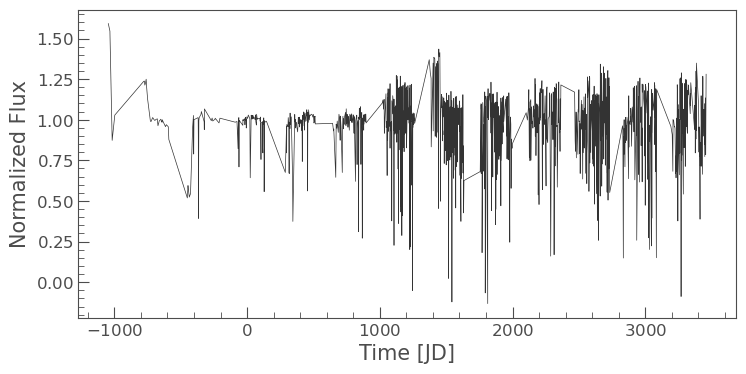

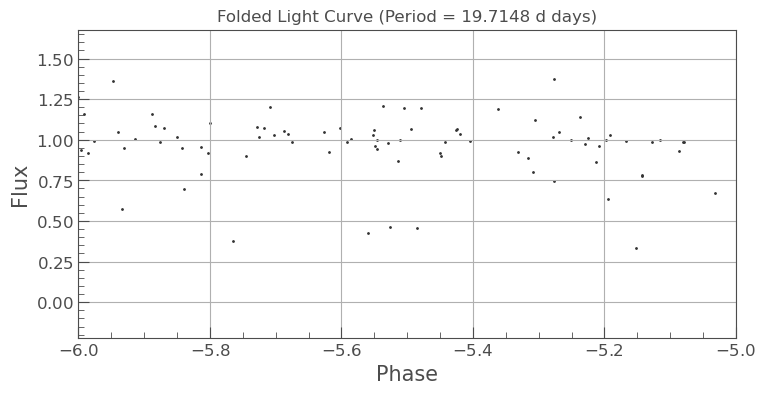

In [6]:
lightcurve = asassn_lc[171799744865]

data = {
    'jd': (lightcurve.data['jd'] - 2457000),  
    'flux': (lightcurve.data['flux'] / np.median(lightcurve.data['flux']))
}
asassn_df = pd.DataFrame(data)

lc = lk.LightCurve(time=asassn_df['jd'], flux=asassn_df['flux'])
lc = lc.flatten(break_tolerance=50, polyorder=1, sigma=3, niters=3, window_length=250)
lc.plot()
# plt.show()

periodogram = lc.to_periodogram(method='bls', minimum_period=19.5, maximum_period=20)

best_period = periodogram.period_at_max_power
print(f"Best period: {best_period:.4f} days")
folded_lc = lc.fold(period=best_period.value)

folded_lc.scatter()
plt.title(f'Folded Light Curve (Period = {best_period:.4f} days)')
plt.xlabel('Phase')
plt.xlim(-6, -5) # zooming in on the primary eclipse
plt.ylabel('Flux')
plt.grid(True)
plt.show()

Below, we see that data does not exist for the Kepler mission. Kepler only covered 5% of the sky, so this also makes sense. There is also no mission ID for this object on the SIMBAD database.

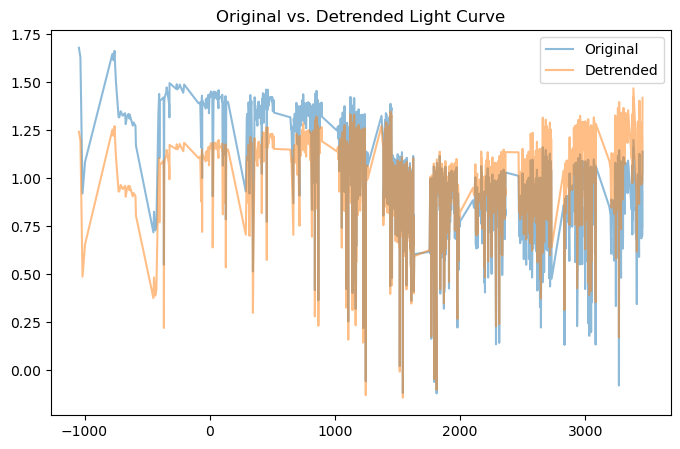

In [7]:
from sklearn.linear_model import LinearRegression


time = asassn_df['jd'].values.reshape(-1, 1)
flux = asassn_df['flux'].values

# fit the linear regression model
model = LinearRegression()
model.fit(time, flux)
trend = model.predict(time)

# detrend the data
detrended_flux = flux - trend + 1

plt.figure(figsize=(8, 5))
plt.plot(asassn_df['jd'], asassn_df['flux'], label='Original', alpha=0.5)
plt.plot(asassn_df['jd'], detrended_flux, label='Detrended', alpha=0.5)
plt.legend()
plt.title('Original vs. Detrended Light Curve')
plt.show()

/Users/carolshao/anaconda3/envs/tess_cbp/lib/python3.12/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 14 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


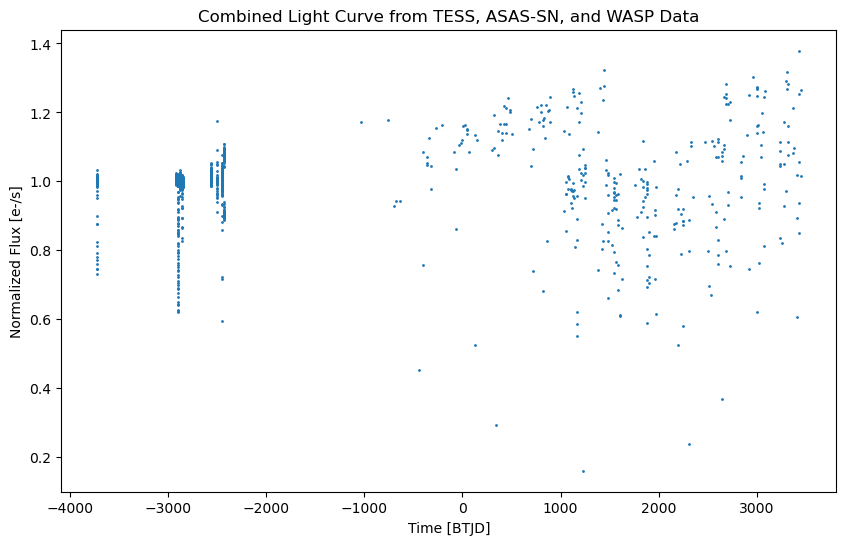

In [8]:
from lightkurve import LightCurve, search_lightcurve

### THE TESS DATA ###
search_result = lk.search_lightcurve('TIC 172900988', mission='TESS')
tess_lc = search_result.download().remove_nans().normalize()
tess_df = pd.DataFrame({
    'jd': tess_lc.time.value,
    'flux': tess_lc.flux.value
})

### THE ASAS-SN DATA ###

asassn_data = {
    'jd': lightcurve.data['jd'] - 2457000,
    'flux': detrended_flux / np.median(detrended_flux)
}
asassn_df = pd.DataFrame(asassn_data)

### THE WASP DATA ###
with open('SWASP/1SWASP_J083438.80+313314.7_lc.tbl', 'r') as my_file:
    for _ in range(22):
        next(my_file)
    
    data = []
    for line in my_file:
        fields = line.split()
        tamflux_value = float(fields[3])
        hjd_value = float(fields[9])
        data.append({'jd': hjd_value, 'flux': tamflux_value})

wasp_df = pd.DataFrame(data)
wasp_df['flux'] = wasp_df['flux'] / (wasp_df['flux'].median()) # normalize
wasp_df['jd'] = wasp_df['jd'] - 2457000 # same units as everything else smh

# COMBINE
combined_df = pd.concat([asassn_df, wasp_df])
combined_df = combined_df.loc[combined_df['flux'] >= 0]

##############################################

# calculate all the possible primary transits
primary_transit = 2507.398
period = 19.6583
primary_lower = np.arange(primary_transit, np.min(combined_df["jd"]) - period, -period)
primary_upper = np.arange(primary_transit + period, np.max(combined_df["jd"]) + period, period)
transit_times = np.concatenate((primary_lower, primary_upper))

def filter_data_around_transits(df, transit_times, window=2):
    """
    Filters the DataFrame to include only rows where the jd value falls within the window around each transit time.
    
    Parameters:
    - df: DataFrame containing the time series data.
    - transit_times: Array of transit times.
    - window: Number of days around each transit time to consider for filtering.
    
    Returns:
    - Filtered DataFrame.
    """
    mask = pd.Series(False, index=df.index)
    for transit in transit_times:
        lower_bound = transit - window
        upper_bound = transit + window
        mask |= (df['jd'] >= lower_bound) & (df['jd'] <= upper_bound)
    return df[mask]
    
filtered_df = filter_data_around_transits(combined_df, transit_times)
# Now, filtered_df contains only the data points within the specified window around each transit time.

plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['jd'], filtered_df['flux'], label='Filtered Data', s=1)

plt.xlabel('Time [BTJD]')
plt.ylabel('Normalized Flux [e-/s]')
plt.title('Combined Light Curve from TESS, ASAS-SN, and WASP Data')
plt.show()

lc = lk.LightCurve(time=filtered_df['jd'], flux=filtered_df['flux']).remove_nans().normalize()
lc = lc.flatten(break_tolerance=500, polyorder=1, sigma=3, niters=10, window_length=250) # we can play with these inputs further

Best period: 19.6583 d days


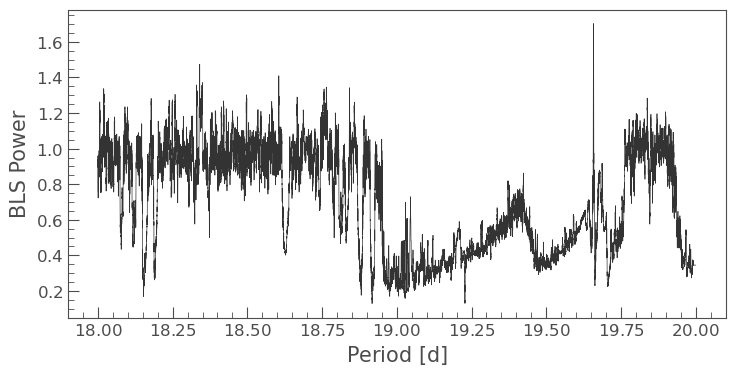

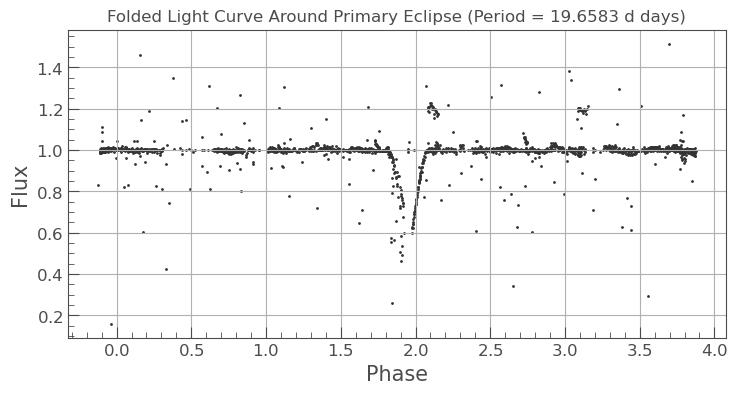

In [9]:
duration = [0.3, 0.5]
periodogram = lc.to_periodogram(method='bls', minimum_period=18, maximum_period=20, duration=duration)

best_period = periodogram.period_at_max_power
print(f"Best period: {best_period:.4f} days")
folded_lc = lc.fold(period=best_period.value)
periodogram.plot()

folded_lc.scatter()
plt.title(f'Folded Light Curve Around Primary Eclipse (Period = {best_period:.4f} days)')
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.grid(True)
plt.show()

Best period: 19.8149 d days


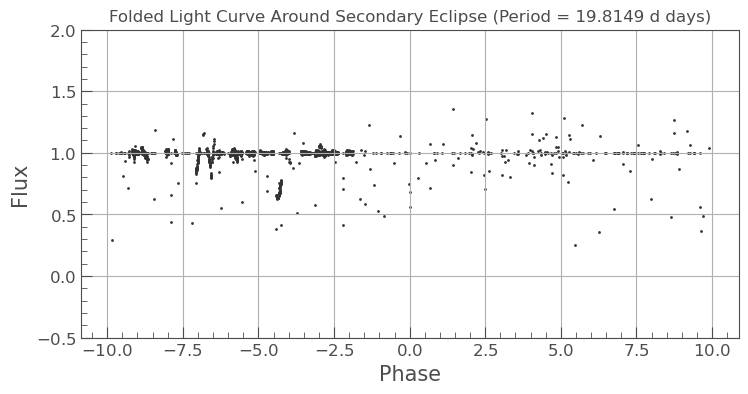

Difference: 0.1565 d


In [10]:
# repeating for the secondary eclipse
secondary_transit = 2519.3

secondary_lower = np.arange(secondary_transit, np.min(combined_df["jd"]) - period, -period)
secondary_upper = np.arange(secondary_transit + period, np.max(combined_df["jd"]) + period, period)
secondary_transit_times = np.concatenate((secondary_lower, secondary_upper))

secondary_filtered_df = filter_data_around_transits(combined_df, secondary_transit_times)

lc2 = lk.LightCurve(time=secondary_filtered_df['jd'], flux=secondary_filtered_df['flux'])
lc2 = lc2.flatten(break_tolerance=500, polyorder=1, sigma=3, niters=10, window_length=250) # we can play with these inputs further

periodogram2 = lc2.to_periodogram(method='bls', minimum_period=18, maximum_period=20, duration=duration)

best_period2 = periodogram2.period_at_max_power
print(f"Best period: {best_period2:.4f} days")
folded_lc2 = lc2.fold(period=best_period2.value)

folded_lc2.scatter()
plt.title(f'Folded Light Curve Around Secondary Eclipse (Period = {best_period2:.4f} days)')
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.ylim(-0.5,2)
plt.grid(True)
plt.show()

print("Difference: {0:.4f}".format(best_period2 - best_period))

Reading in data from WASP (obtained from wget script). The first 22 lines are header information and not useful to us, so we will skip all of them to get the actual measurements from the telescope. As a sanity check, see that NUMRECORDS = 9067 is the same as the row dimension we ultimately get, also 9067.

That's a good set there, but a stretch goal once you get beyond those is to start looking at the TESS catalog of eclipsing binaries: https://tessebs.villanova.edu/. Which of these would make good candidates for us to look across these catalogs for precession? We will need: Both primary and secondary eclipses to be observable, a nonzero eccentricity (so the phase of the secondary relative to the primary is in 0<phi<0.48 or 0.52<phi<1.0, or thereabouts, and them to not be too close/a contact binary/having strong tidal interactions, so we probably want to toss anything with an orbital period < 1 day. That might grow outwards to 2, 3, or 5 days, but that's a good starting point. With those constraints, how many candidates do we have to explore?


We will use TESS as the ground truth. 

In [22]:
import warnings
from lightkurve import search_lightcurve
warnings.filterwarnings('ignore')

def filter_data_around_transits(df, transit_times, window=2):
    """
    Filters the DataFrame to include only rows where the jd value falls within the window around each transit time.
    
    Parameters:
    - df: DataFrame containing the time series data.
    - transit_times: Array of transit times.
    - window: Number of days around each transit time to consider for filtering.
    
    Returns:
    - Filtered DataFrame.
    """
    mask = pd.Series(False, index=df.index)
    for transit in transit_times:
        lower_bound = transit - window
        upper_bound = transit + window
        mask |= (df['jd'] >= lower_bound) & (df['jd'] <= upper_bound)
    return df[mask]


def filter_data(df, quality, flux_threshold):
    """Filter data based on quality and flux."""
    return df[(df['quality'] == quality) & (df['flux'] >= flux_threshold)]


def detrend_data(df):
    """Fit linear regression model to predict detrended data."""
    time = df['jd'].values.reshape(-1, 1)
    flux = df['flux'].values
    
    model = LinearRegression()
    model.fit(time, flux)
    trend = model.predict(time)
    
    detrended_flux = flux - trend + 1

    df['flux'] = detrended_flux

    return df
    

def add_tess_points(df):
    df['jd_diff'] = df['jd'].diff()
    
    filtered_rows = df[df['jd_diff'] > 0.1]
    
    # for each group of consecutive 'jd' values that are less than or equal to 0.1 apart,
    # create a new row with 'jd' incremented by 0.1 and 'flux' set to 1.0
    new_rows = []
    for _, group in filtered_rows.groupby(filtered_rows.index // 10):
        new_row = {'jd': group.iloc[0]['jd'] + 0.1 * len(group), 'flux': 1.0}
        new_rows.append(new_row)
    
    combined_rows = pd.concat([df.drop(columns=['jd_diff']), pd.DataFrame(new_rows)])
    
    final_df = combined_rows.drop_duplicates(subset='jd', keep='first')
    
    final_df.reset_index(drop=True, inplace=True)
    return final_df


def chi_squared(tess_df, comparison_df, primary_period, primary_transit):
    folded_tess = lk.LightCurve(time=tess_df['jd'], 
                             flux=tess_df['flux']).fold(period=primary_period, epoch_time=primary_transit)
    folded_comparison = lk.LightCurve(time=comparison_df['jd'], 
                               flux=comparison_df['flux']).fold(period=primary_period, epoch_time=primary_transit)

    folded_tess_df = pd.DataFrame({'jd': folded_tess.time.value, 'flux': folded_tess.flux.value})
    folded_comparison_df = pd.DataFrame({'jd': folded_comparison.time.value, 'flux': folded_comparison.flux.value, 
                                         'flux_err': comparison_df['flux_err']}) # we already calculated and added 'flux_err' previously

    # calculate sd of comparison dataset's flux errors


    comparison_err = np.std(folded_comparison_df['flux'])
    chi_squared_values = []
    chi_squared_sum = 0
    
    for _, row in folded_comparison_df.iterrows():
        comparison_phase = row['jd']
        comparison_flux = row['flux']
        
        differences = np.abs(folded_tess_df['jd'] - comparison_phase)
    
        closest_idx = differences.argmin()
        
        closest_tess_flux = folded_tess_df.loc[closest_idx, 'flux']
        
        chi_squared = ((comparison_flux - closest_tess_flux) / comparison_err)**2
        chi_squared_sum += chi_squared
        
    return chi_squared_sum


def automate_primary_periodogram(tid, wasp_filepath, primary_transit, min_period, max_period, duration = [0.3, 0.5]):
    """
    Generates a primary periodogram for a given TESS ID, incorporating WASP and ASAS-SN data.

    Parameters:
    - tid (str): TESS ID of the target.
    - wasp_filepath (str): Path to WASP data file.
    - primary_transit (float): JD of primary transit epoch.
    - min_period (float): Minimum period for periodogram.
    - max_period (float): Maximum period for periodogram.

    Displays a scatter plot of the folded light curve around the primary eclipse.
    """
    # get the TESS data
    try:
        tid_str = str(tid)
        search_result = search_lightcurve(tid_str, mission='TESS')
        tess_lc = search_result.download().remove_nans().normalize()
    except Exception as e:
        print(f"Error processing {tid} ({type(e).__name__}): {e}")

    # detrend method requires a df, so convert tess_lc to a dataframe
    tess_df = pd.DataFrame({
        'jd': tess_lc.time.value,
        'flux': tess_lc.flux.value
    })
    tess_df = detrend_data(tess_df)

    # also add points to tess
    tess_df = add_tess_points(tess_df)

    
    # find the coordinates of the object with the provided tid
    tic_info = Catalogs.query_object(tid, radius=0.001, catalog="TIC")
    if tic_info is not None and len(tic_info) > 0:
        ra = tic_info[0]['ra']
        dec = tic_info[0]['dec']
        radius = tic_info[0]['rad']
    
    # query for the asas-sn object id
    query = f"""
    SELECT 
     * 
    FROM master_list 
    WHERE DISTANCE(ra_deg, dec_deg, {ra}, {dec}) <= 0.01
    """
    asassn_query = client.adql_query(query, download=True)

    asassn_lc = asassn_query[asassn_query.data['asas_sn_id'][0]]

    # step 1: filter
    asassn_df = filter_data(asassn_lc.data, 'G', 0)

    # step 2: normalize
    asassn_median = asassn_df['flux'].median()
    
    asassn_data = {
        'jd': asassn_df['jd'] - 2457000,
        'flux': asassn_df['flux'] / asassn_median,
        'flux_err': asassn_df['flux_err'],
        'phot_filter': asassn_df['phot_filter']
    }
    asassn_df = pd.DataFrame(asassn_data)

    # step 3: detrend
    filters = ['g', 'V']
    all_detrended_data = []
    
    for filter_type in filters:
        filtered_data = asassn_df[asassn_df['phot_filter'] == filter_type]
    
        all_detrended_data.append(detrend_data(filtered_data))

    detrended_asassn_df = pd.concat(all_detrended_data)

    asassn_detrended = {
        'jd': detrended_asassn_df['jd'],
        'flux': detrended_asassn_df['flux'],
        'flux_err': asassn_df['flux_err'] / (detrended_asassn_df['flux']).median(),
    }
    
    asassn_df = pd.DataFrame(asassn_detrended)
    
    # obtain the wasp data
    wasp_filepath = str(wasp_filepath)
    with open(wasp_filepath, 'r') as my_file:
        for _ in range(22):
            next(my_file)
        
        data = []
        for line in my_file:
            fields = line.split()
            tamflux2_value = float(fields[3])
            tamflux2_err_value = float(fields[4])
            hjd_value = float(fields[9])
            data.append({'jd': hjd_value, 'flux': tamflux2_value, 'flux_err': tamflux2_err_value})
    
    wasp_df = pd.DataFrame(data)
    
    # normalize
    wasp_median = wasp_df['flux'].median()
    
    wasp_data = {
        'jd': wasp_df['jd'] - 2457000,
        'flux': wasp_df['flux'] / wasp_median,
        'flux_err': wasp_df['flux_err'] / wasp_median,
    }
    wasp_df = pd.DataFrame(wasp_data)

    # detrend wasp
    wasp_df = detrend_data(wasp_df)
    
    # combine the data + filter 
    combined_df = pd.concat([tess_df, asassn_df, wasp_df])
    
    # period calculation using minimizing chi-squared method:
    periods = np.arange(min_period, max_period, 0.0001)
    chi_squared_values = []
    counter = 0

    for period in periods:
        transit_times = np.concatenate((np.arange(primary_transit, np.min(combined_df["jd"]) - period, -period), 
                                        np.arange(primary_transit + period, np.max(combined_df["jd"]) + period, period)))

        filtered_tess_df = filter_data_around_transits(tess_df, transit_times)
        filtered_asassn_df = filter_data_around_transits(asassn_df, transit_times)
        filtered_wasp_df = filter_data_around_transits(wasp_df, transit_times)
        
        chi_squared_sum = chi_squared(filtered_tess_df, filtered_asassn_df, period, primary_transit) + chi_squared(filtered_tess_df, filtered_wasp_df, period, primary_transit)

        chi_squared_values.append(chi_squared_sum)

    best_predicted_period = periods[np.argmin(chi_squared_values)]
    
    plt.figure(figsize=(10, 6))  # Optional: Adjust figure size
    plt.plot(periods, chi_squared_values)
    
    index_of_best_period = list(periods).index(best_predicted_period)
    plt.plot(best_predicted_period, chi_squared_values[index_of_best_period], 'ro') # 'ro' stands for red circle
    
    plt.xlabel('Period')
    plt.ylabel('Chi-Squared')
    plt.title(f'Best Predicted Period: {best_predicted_period:.5f}')
    plt.grid()
    plt.show()

Pulled 1 of 1


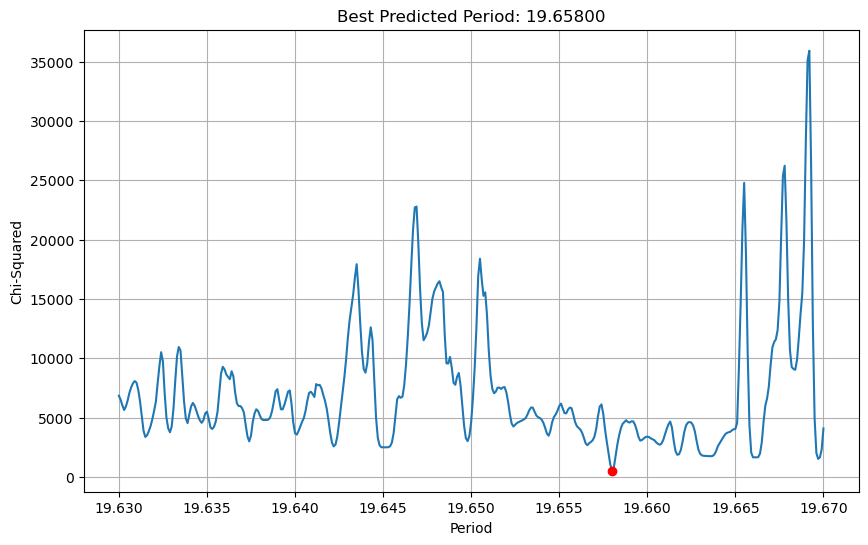

In [23]:
automate_primary_periodogram(tid='TIC 172900988', wasp_filepath='SWASP/1SWASP_J083438.80+313314.7_lc.tbl', primary_transit=2507.398, 
                             min_period=19.63, max_period=19.67)

def automate_primary_periodogram(tid, wasp_filepath, primary_transit, min_period, max_period, duration = [0.3, 0.5]):
    try:
        tid_str = str(tid)
        search_result = search_lightcurve(tid_str, mission='TESS')
        tess_lc = search_result.download().remove_nans().normalize()
    except Exception as e:
        print(f"Error processing {tid} ({type(e).__name__}): {e}")

    # detrend method requires a df
    tess_df = pd.DataFrame({
        'jd': tess_lc.time.value,
        'flux': tess_lc.flux.value
    })
    tess_df = detrend_data(tess_df)
    tess_lc = lk.LightCurve(time=tess_df['jd'], flux=tess_df['flux'])
    
    # find the coordinates of the object with the provided tid
    tic_info = Catalogs.query_object(tid, radius=0.001, catalog="TIC")
    if tic_info is not None and len(tic_info) > 0:
        ra = tic_info[0]['ra']
        dec = tic_info[0]['dec']
        radius = tic_info[0]['rad']
    
    # query for the asas-sn object id
    query = f"""
    SELECT 
     * 
    FROM master_list 
    WHERE DISTANCE(ra_deg, dec_deg, {ra}, {dec}) <= 0.01
    """
    asassn_query = client.adql_query(query, download=True)

    asassn_lc = asassn_query[asassn_query.data['asas_sn_id'][0]]

    filters = ['g', 'V']
    all_detrended_data = []
    
    for filter_type in filters:
        filtered_data = filter_data(asassn_lc.data[asassn_lc.data['phot_filter'] == filter_type], 'G', 0)
        
        all_detrended_data.append(detrend_data(filtered_data))
    
    asassn_df = pd.concat(all_detrended_data).reset_index(drop=True)
    

    # obtain the wasp data
    wasp_filepath = str(wasp_filepath)
    with open(wasp_filepath, 'r') as my_file:
        for _ in range(22):
            next(my_file)
        
        data = []
        for line in my_file:
            fields = line.split()
            tamflux2_value = float(fields[3])
            hjd_value = float(fields[9])
            data.append({'jd': hjd_value, 'flux': tamflux2_value})
    
    wasp_df = pd.DataFrame(data)

    # combine the data + do normalizations
    asassn_df['dataset_marker'] = 'A'
    tess_df['dataset_marker'] = 'T'
    combined_df = pd.concat([asassn_df, tess_df])

    print(combined_df)
    combined_df['flux'] = combined_df['flux'] / combined_df['flux'].median() 
    combined_df['jd'] = combined_df['jd'] - 2457000 

    period_range = (18, 18.0002)
    step_size = 0.0001

    marker_to_color = {'A': 'red', 'T': 'blue'}
    
    # Plot folded light curves for each period
    for period in np.arange(period_range[0], period_range[1] + step_size, step_size):

        transit_times = np.concatenate((np.arange(primary_transit, np.min(combined_df["jd"]) - period, -period), 
                                        np.arange(primary_transit + period, np.max(combined_df["jd"]) + period, period)))

        filtered_df = filter_data_around_transits(combined_df, transit_times)
    
        plt.figure(figsize=(10, 6))
    
        for jd, flux, marker in zip(filtered_df['jd'], filtered_df['flux'], filtered_df['dataset_marker']):
            color = marker_to_color.get(marker, 'gray')  # default color if not found

            # TODO: match each asas-sn point to its closest tess point

            # TODO: calculate chi squared by doing sum[(f_tess - f_asassn)/sigma_asassn]^2

        # TODO: plot chi squared against entire period range 
            plt.scatter(jd % period, flux, label=f'Period {period:.5f}', c=color, s=0.5)
            plt.ylim(-2,3)


In [13]:
possible_candidates = ['TIC 0001003831', 'TIC 0001220444', 'TIC 0002020964', 'TIC 0002372579', 'TIC 0003815360',
'TIC 0003816260', 'TIC 0004723156', 'TIC 0005703872', 'TIC 0006518047', 'TIC 0007695666',
'TIC 0008200343', 'TIC 0009033144', 'TIC 0009209932', 'TIC 0010057647', 'TIC 0010891640',
'TIC 0011046410']